## 1. Импорт  библиотек

In [3]:
import random
import math
import copy

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import os
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import torch
from kan import KAN

from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
#%load_ext autotime

C:\Users\Gavriil\AppData\Local\Temp\ipykernel_28692\581288377.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
from tools import KAN_es

## 2. Реализация необходимых функций

### 2.1.1. Функция создания набора данных

In [5]:
def create_XY_data(source_data, output_parameter, geophysical_method, samples_number = "all"):
    
    _source_data = copy.deepcopy(source_data)
    _output_parameter = copy.deepcopy(output_parameter)
    _geophysical_method = copy.deepcopy(geophysical_method)
    _samples_number = copy.deepcopy(samples_number)
    
    
    if not(_output_parameter in ['H1_8', 'H2_8', 'H3_8']):
        print("Error: output parameter is not in the list")
        return 
    
    if not(_geophysical_method in ['G', 'M', 'T', 'GM', 'GT', 'MT','GMT']):
        print("Error: physical_method is not in the list!")
        return
    
    if _samples_number == "all":
        _samples_number = len(_source_data)
    
    #TODO: Create checking sourse data
    
    if _geophysical_method == 'G':
        _X_data = _source_data.iloc[:_samples_number, :31]
        _Y_data = _source_data[[_output_parameter]].iloc[:_samples_number,:]
    elif _geophysical_method == 'M':
        _X_data = _source_data.iloc[:_samples_number, 31:62]
        _Y_data = _source_data[[_output_parameter]].iloc[:_samples_number,:]        
    elif _geophysical_method == 'T':
        _X_data = _source_data.iloc[:_samples_number, 62:124]
        _Y_data = _source_data[[_output_parameter]].iloc[:_samples_number,:]
    elif _geophysical_method == 'GM':
        _X_data = _source_data.iloc[:_samples_number, :62]
        _Y_data = _source_data[[_output_parameter]].iloc[:_samples_number,:]
    elif _geophysical_method == 'GT':
        _X_data = pd.concat([_source_data.iloc[:_samples_number, :31], 
                             _source_data.iloc[:_samples_number, 62:124]], 
                             axis=1, sort=False, ignore_index=False)
        _Y_data = _source_data[[_output_parameter]].iloc[:_samples_number,:]              
    elif _geophysical_method == 'MT':
        _X_data = _source_data.iloc[:_samples_number, 31:124]
        _Y_data = _source_data[[_output_parameter]].iloc[:_samples_number,:]       
    elif _geophysical_method == 'GMT':
        _X_data = _source_data.iloc[:_samples_number, :124]
        _Y_data = _source_data[[_output_parameter]].iloc[:_samples_number,:]
                        
    return _X_data, _Y_data   

### 2.1.2. Функция построения графика обучения

In [6]:
def plot_history_NN(history_NN, model_name, dir_path):
    
    _history_NN = copy.deepcopy(history_NN)
    _model_name = copy.deepcopy(model_name)
    _dir_path = copy.deepcopy(dir_path)
      
    _fig, _ax = plt.subplots(figsize=(6, 4))
       
    _ax.plot(_history_NN.index, _history_NN["loss"],
             label=f"Training MSE", 
             lw=1, color='#FFAD00')
    
    _ax.plot(_history_NN.index, _history_NN["val_loss"], 
             label="Validation MSE",
             lw=1, color='#00873E')
    
    _ax.set_ylabel("MSE")
    _ax.set_xlabel('Number of epoch', labelpad=10.0)
    _ax.legend()
    _ax.set_title(_model_name)
    
    plt.tight_layout()
    
    #plt.savefig(_dir_path+"/"+_model_name+".png")
    plt.show()

### 2.1.3. Функция обучения исходных сетей

In [7]:
def train_NN(trn_data, vld_data, 
             geophysical_method, output_parameter, samples_number, randomseed, 
             model_name_template):
    
    _trn_data = copy.deepcopy(trn_data) 
    _vld_data = copy.deepcopy(vld_data)
    _geophysical_method = copy.deepcopy(geophysical_method)
    _output_parameter = copy.deepcopy(output_parameter)    
    _samples_number = copy.deepcopy(samples_number)  
    _randomseed = copy.deepcopy(randomseed)
    _model_name_template = copy.deepcopy(model_name_template)
    
    
    _model_name = (_model_name_template + "_" + 
                   _geophysical_method + "_" + 
                   str(_samples_number) + "_" +
                   _output_parameter + "_rs" +
                   str(_randomseed))
                               
    ### Create input-output data
    
    _dataset_sizes = {"all":"all", 3500:1000, 1750:500, 1000:300, 700:200, 350:100, 175:50}
    _X_trn, _Y_trn = create_XY_data(_trn_data, _output_parameter, _geophysical_method, _samples_number)
    _X_vld, _Y_vld = create_XY_data(_vld_data, _output_parameter, _geophysical_method, _dataset_sizes[_samples_number])
    
    ### Create model
    
    tf.keras.utils.set_random_seed(_randomseed)
    
    _model = tf.keras.models.Sequential() 
    _model.add(tf.keras.layers.Dense(32, activation=tf.nn.sigmoid))
    _model.add(tf.keras.layers.Dense(1,  activation=None))    

    _optimizer = keras.optimizers.SGD(learning_rate = 0.1,#0.001,
                                      momentum = 0.5,
                                      nesterov=True)
        
    _model.compile(_optimizer, loss=tf.keras.losses.MeanSquaredError())
    
    _early_stopping = EarlyStopping(monitor='val_loss',
                                    min_delta=0.001*0.05,#0.0001, 
                                    patience=500,#500,
                                    restore_best_weights=True)
      
    ### Train model
    print("Start train model:", _model_name)

    _history = _model.fit(x=_X_trn, y=_Y_trn,
                          batch_size=math.ceil(len(_X_trn) * 0.05),
                          epochs=50000, #100000,
                          verbose=2,
                          callbacks=[_early_stopping],
                          validation_data=(_X_vld, _Y_vld))

    _n_epochs = len(_history.history['loss'])
    
    print('Number of epochs for training NN model:' + str(_n_epochs))
    
    ### Save model
    
    #_model.save(_dir_path+"/"+ _model_name+".keras")
    
    _history_df = pd.DataFrame(_history.history)
    #plot_history_NN(_history_df, _model_name, _dir_path)
    
    #_history_df.to_csv(_dir_path+"/"+ _model_name + '_history.csv')
    
    return _model, _history_df, _n_epochs

In [8]:
def vector_pred_NN(trn_data, vld_data, tst_data,
                geophysical_method, l_output_parameter, samples_number, randomseed, 
                model_name_template):
    '''Conducting prediction for each output from l_output_parameter. 
    One NN for each output_parameter from l_output_parameter.
    Return vector [mae, mse, r2]
    '''
    _geophysical_method = copy.deepcopy(geophysical_method)
    _tst_data = copy.deepcopy(tst_data)

    _X_tst, _Y_tst = create_XY_data(_tst_data, l_output_parameter[0], _geophysical_method, "all")

    _vector_Y_pred = np.array([[] for i in range(_Y_tst.shape[0])])
    _vector_Y_tst = np.array([[] for i in range(_Y_tst.shape[0])])

    for output_parameter in l_output_parameter:
        model = train_NN(trn_data, vld_data, 
                geophysical_method, output_parameter, samples_number, randomseed, 
                model_name_template)
        
        
        _output_parameter = copy.deepcopy(output_parameter)
        _X_tst, _Y_tst = create_XY_data(_tst_data, _output_parameter, _geophysical_method, "all")
        _Y_pred = model[0].predict(_X_tst).reshape(-1, 1)

        _vector_Y_pred = np.concatenate((_vector_Y_pred, _Y_pred), axis=1)
        _vector_Y_tst = np.concatenate((_vector_Y_tst, _Y_tst), axis=1)

    _mae = round(mean_absolute_error(_vector_Y_tst, _vector_Y_pred), 5)
    _rmse = round(mean_squared_error(_vector_Y_tst, _vector_Y_pred, squared = False), 5)
    _r2 = round(r2_score(_vector_Y_tst, _vector_Y_pred), 5)

    return [_mae, _rmse, _r2]

### 2.1.4. Функция применения сетей

In [9]:
def app_stat_NN(model, tst_data, 
                geophysical_method, output_parameter, samples_number, randomseed, 
                file_name_template, file_name_suffix):
        
    _tst_data = copy.deepcopy(tst_data) 
    _geophysical_method = copy.deepcopy(geophysical_method)
    _output_parameter = copy.deepcopy(output_parameter)
    _samples_number = copy.deepcopy(samples_number) 
    _randomseed = copy.deepcopy(randomseed)    
    _file_name_template = copy.deepcopy(file_name_template)
    _file_name_suffix = copy.deepcopy(file_name_suffix)    
    #_dir_path = copy.deepcopy(dir_path)
    
    _file_name =  (_file_name_template + "_" + 
                   _geophysical_method + "_" + 
                   str(_samples_number) + "_" +
                   _output_parameter + "_rs" +
                   str(_randomseed) + "_" + 
                   file_name_suffix)
      
    ### Create input-output data
    
    _X_tst, _Y_tst = create_XY_data(_tst_data, _output_parameter, _geophysical_method, "all")
  
    ### Apply and calculate statistics

    _Y_pred = model[0].predict(_X_tst).reshape(-1, 1)
    
    _mae = round(mean_absolute_error(_Y_tst, _Y_pred), 5)
    _rmse = round(mean_squared_error(_Y_tst, _Y_pred, squared = False), 5)
    _r2 = round(r2_score(_Y_tst, _Y_pred), 5)



    #_statistics_DF = pd.DataFrame({'epochs': model[2]-500, 'MAE': _mae, 'RMSE':_rmse, 'R2': _r2}, 
    #                              index=[_file_name])
    
    #print(_statistics_DF)
    
    #_statistics_DF.to_csv(_dir_path+"/"+ _file_name + '.csv')
    
    #return _statistics_DF
    return [_rmse, _mae, _r2]

In [10]:
def alg_keras_mlp(trn_data, vld_data, tst_data,
             geophysical_method, output_parameter, randomseed
             ):
    
    keras_nn = train_NN(trn_data, vld_data,
                         geophysical_method,
                         output_parameter, 
                         "all", randomseed, 
                         "?")
            
    stat_DF = app_stat_NN(keras_nn, tst_data,
                      geophysical_method,
                      output_parameter, 
                      "all", randomseed, 
                      "stat_udus", "?")
    
    return stat_DF

In [11]:
def scatter_prediction_keras_mlp(model, data, 
                                geophysical_method, output_parameter, samples_number, randomseed, 
                                file_name_template, file_name_suffix, dir_path,
                                title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    _data = copy.deepcopy(data) 
    _geophysical_method = copy.deepcopy(geophysical_method)
    _output_parameter = copy.deepcopy(output_parameter)
    _samples_number = copy.deepcopy(samples_number) 
    _randomseed = copy.deepcopy(randomseed)    
    _file_name_template = copy.deepcopy(file_name_template)
    _file_name_suffix = copy.deepcopy(file_name_suffix)    
    _dir_path = copy.deepcopy(dir_path)
    
    _file_name =  (_file_name_template + "_" + 
                   _geophysical_method + "_" + 
                   str(_samples_number) + "_" +
                   _output_parameter + "_rs" +
                   str(_randomseed) + "_" + 
                   file_name_suffix)
      
    ### Create input-output data
    
    _X_tst, _Y_tst = create_XY_data(_data, _output_parameter, _geophysical_method, "all")
  
    ### Apply and calculate statistics

    _Y_pred = model[0].predict(_X_tst).reshape(-1, 1)

    y_true = _Y_tst.to_numpy().T.ravel()
    y_pred = _Y_pred.T.ravel()

    _mae = round(mean_absolute_error(_Y_tst, _Y_pred), 5)
    _rmse = round(mean_squared_error(_Y_tst, _Y_pred, squared = False), 5)
    _r2 = round(r2_score(_Y_tst, _Y_pred), 5)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MAE={round(_mae, 5)} | RMSE={round(_rmse, 5)} | R2={round(_r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")

    plt.show()


## 3. Обучение нейронных сетей

### 3.0. Загрузка наборов данных

In [12]:
'''
initial_trn_data_fdfs = pd.read_csv("datasets_mtgm\mtgm_fdfs_10k_trn.csv")
initial_vld_data_fdfs = pd.read_csv("datasets_mtgm\mtgm_fdfs_10k_vld.csv")
initial_tst_data_fdfs = pd.read_csv("datasets_mtgm\mtgm_fdfs_10k_tst.csv")

initial_trn_data_udfs = pd.read_csv("datasets_mtgm\mtgm_udfs_10k_trn.csv")
initial_vld_data_udfs = pd.read_csv("datasets_mtgm\mtgm_udfs_10k_vld.csv")
initial_tst_data_udfs = pd.read_csv("datasets_mtgm\mtgm_udfs_10k_tst.csv")

initial_trn_data_udus = pd.read_csv("datasets_mtgm\mtgm_udus_10k_trn.csv")
initial_vld_data_udus = pd.read_csv("datasets_mtgm\mtgm_udus_10k_vld.csv")
initial_tst_data_udus = pd.read_csv("datasets_mtgm\mtgm_udus_10k_tst.csv")
'''
# !Some troubles with *.csv naming!

initial_trn_data_fdfs = pd.read_csv("datasets_mtgm\mtgm_fdfs_10k_trn.csv")
initial_vld_data_fdfs = pd.read_csv("datasets_mtgm\mtgm_fdfs_10k_tst.csv")
initial_tst_data_fdfs = pd.read_csv("datasets_mtgm\mtgm_fdfs_10k_pro.csv")

initial_trn_data_udfs = pd.read_csv("datasets_mtgm\mtgm_udfs_10k_trn.csv")
initial_vld_data_udfs = pd.read_csv("datasets_mtgm\mtgm_udfs_10k_tst.csv")
initial_tst_data_udfs = pd.read_csv("datasets_mtgm\mtgm_udfs_10k_pro.csv")

initial_trn_data_udus = pd.read_csv("datasets_mtgm\mtgm_udus_10k_trn.csv")
initial_vld_data_udus = pd.read_csv("datasets_mtgm\mtgm_udus_10k_tst.csv")
initial_tst_data_udus = pd.read_csv("datasets_mtgm\mtgm_udus_10k_pro.csv")

In [13]:
data_col_names = initial_trn_data_udus.columns
data_col_names

Index(['G_1', 'G_2', 'G_3', 'G_4', 'G_5', 'G_6', 'G_7', 'G_8', 'G_9', 'G_10',
       ...
       'E3_6', 'E3_7', 'E3_8', 'E3_9', 'E3_10', 'E3_11', 'E3_12', 'E3_13',
       'E3_14', 'E3_15'],
      dtype='object', length=304)

### 3.1. Шкалирование данных

In [14]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(pd.concat([initial_trn_data_fdfs,
                         initial_trn_data_udfs, 
                         initial_trn_data_udus],
                        axis=0, sort=False, ignore_index=True))

MinMaxScaler()

In [15]:
scaled_trn_data_fdfs = pd.DataFrame(mm_scaler.transform(initial_trn_data_fdfs),columns=data_col_names) 
scaled_vld_data_fdfs = pd.DataFrame(mm_scaler.transform(initial_vld_data_fdfs),columns=data_col_names)
scaled_tst_data_fdfs = pd.DataFrame(mm_scaler.transform(initial_tst_data_fdfs),columns=data_col_names)

scaled_trn_data_udfs = pd.DataFrame(mm_scaler.transform(initial_trn_data_udfs),columns=data_col_names)
scaled_vld_data_udfs = pd.DataFrame(mm_scaler.transform(initial_vld_data_udfs),columns=data_col_names)
scaled_tst_data_udfs = pd.DataFrame(mm_scaler.transform(initial_tst_data_udfs),columns=data_col_names)

scaled_trn_data_udus = pd.DataFrame(mm_scaler.transform(initial_trn_data_udus),columns=data_col_names)
scaled_vld_data_udus = pd.DataFrame(mm_scaler.transform(initial_vld_data_udus),columns=data_col_names)
scaled_tst_data_udus = pd.DataFrame(mm_scaler.transform(initial_tst_data_udus),columns=data_col_names)

### 3.2. Параметры обучения

In [181]:
RANDOM_SEEDS = [111, 222, 333, 444, 555]
GEOPHYSICAL_METHODS = ['G', 'M', 'T', 'GM', 'GT', 'MT','GMT']
DETERMINED_PARAMETERS = ['H1_8', 'H2_8', 'H3_8']
DATASET_SIZES = [3500, 1750, 1000, 700, 350, 175]

### Try learn 1 NN

In [18]:
geophysical_method = 'GMT'
determined_parameter = 'H1_8'
RS = 1

scaled_trn_data = scaled_trn_data_fdfs
scaled_vld_data = scaled_vld_data_fdfs
scaled_tst_data = scaled_tst_data_fdfs

In [19]:
alg_keras_mlp(scaled_trn_data, scaled_vld_data, scaled_tst_data,
              geophysical_method, determined_parameter, randomseed=1)

Start train model: ?_GMT_all_H1_8_rs1
Epoch 1/50000
20/20 - 1s - 35ms/step - loss: 0.6311 - val_loss: 0.0672
Epoch 2/50000
20/20 - 0s - 4ms/step - loss: 0.0689 - val_loss: 0.0637
Epoch 3/50000
20/20 - 0s - 4ms/step - loss: 0.0650 - val_loss: 0.0595
Epoch 4/50000
20/20 - 0s - 4ms/step - loss: 0.0603 - val_loss: 0.0546
Epoch 5/50000
20/20 - 0s - 4ms/step - loss: 0.0549 - val_loss: 0.0492
Epoch 6/50000
20/20 - 0s - 5ms/step - loss: 0.0490 - val_loss: 0.0435
Epoch 7/50000
20/20 - 0s - 4ms/step - loss: 0.0430 - val_loss: 0.0379
Epoch 8/50000
20/20 - 0s - 4ms/step - loss: 0.0372 - val_loss: 0.0327
Epoch 9/50000
20/20 - 0s - 4ms/step - loss: 0.0320 - val_loss: 0.0283
Epoch 10/50000
20/20 - 0s - 5ms/step - loss: 0.0276 - val_loss: 0.0248
Epoch 11/50000
20/20 - 0s - 5ms/step - loss: 0.0241 - val_loss: 0.0220
Epoch 12/50000
20/20 - 0s - 5ms/step - loss: 0.0214 - val_loss: 0.0198
Epoch 13/50000
20/20 - 0s - 5ms/step - loss: 0.0192 - val_loss: 0.0181
Epoch 14/50000
20/20 - 0s - 5ms/step - loss: 0.

c:\Users\Gavriil\VS_projects\KAN_geo\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0.02172, 0.01733, 0.99327]

In [17]:
geophysical_method = 'GMT'
determined_parameter = 'H1_8'
RS = 1

scaled_trn_data = scaled_trn_data_fdfs
scaled_vld_data = scaled_vld_data_fdfs
scaled_tst_data = scaled_tst_data_fdfs



keras_nn = train_NN(scaled_trn_data, scaled_vld_data,
                         geophysical_method,
                         determined_parameter, 
                         "all", RS, 
                         "net_udus")

stat_DF = app_stat_NN(keras_nn, scaled_tst_data,
                      geophysical_method,
                      determined_parameter, 
                      "all", RS, 
                      "stat_udus", "to_udfs")
            
#all_stat_DF = pd.concat([all_stat_DF, stat_DF], axis=0, sort=False) 

Start train model: net_udus_G_all_H1_8_rs1
Epoch 1/50000
20/20 - 0s - 25ms/step - loss: 0.8720 - val_loss: 0.0600
Epoch 2/50000
20/20 - 0s - 3ms/step - loss: 0.0563 - val_loss: 0.0489
Epoch 3/50000
20/20 - 0s - 3ms/step - loss: 0.0466 - val_loss: 0.0411
Epoch 4/50000
20/20 - 0s - 3ms/step - loss: 0.0396 - val_loss: 0.0355
Epoch 5/50000
20/20 - 0s - 3ms/step - loss: 0.0344 - val_loss: 0.0314
Epoch 6/50000
20/20 - 0s - 4ms/step - loss: 0.0306 - val_loss: 0.0283
Epoch 7/50000
20/20 - 0s - 4ms/step - loss: 0.0277 - val_loss: 0.0260
Epoch 8/50000
20/20 - 0s - 3ms/step - loss: 0.0254 - val_loss: 0.0241
Epoch 9/50000
20/20 - 0s - 4ms/step - loss: 0.0236 - val_loss: 0.0227
Epoch 10/50000
20/20 - 0s - 3ms/step - loss: 0.0222 - val_loss: 0.0215
Epoch 11/50000
20/20 - 0s - 3ms/step - loss: 0.0211 - val_loss: 0.0206
Epoch 12/50000
20/20 - 0s - 4ms/step - loss: 0.0201 - val_loss: 0.0198
Epoch 13/50000
20/20 - 0s - 3ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 14/50000
20/20 - 0s - 4ms/step - los

c:\Users\Gavriil\VS_projects\KAN_geo\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Gavriil\VS_projects\KAN_geo\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


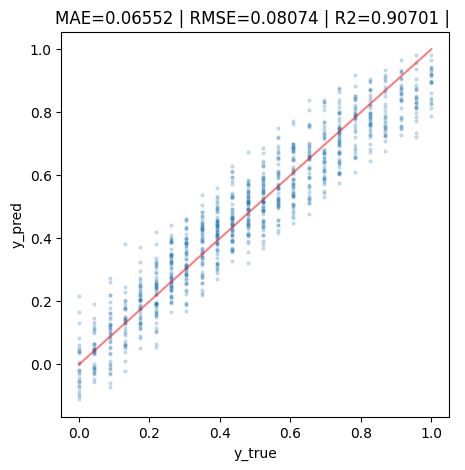

In [307]:
scatter_prediction_keras_mlp(keras_nn, scaled_tst_data,
                             geophysical_method,
                             determined_parameter,
                             "all", RS,
                             "stat_udus", "to_udfs", "stat_udus_udfs"
                             )

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
[[0.551257   0.551257  ]
 [0.70878285 0.70878285]
 [0.47399735 0.47399735]
 ...
 [0.55283403 0.55283403]
 [0.48027736 0.48027736]
 [0.65163535 0.65163535]]


c:\Users\Gavriil\VS_projects\KAN_geo\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


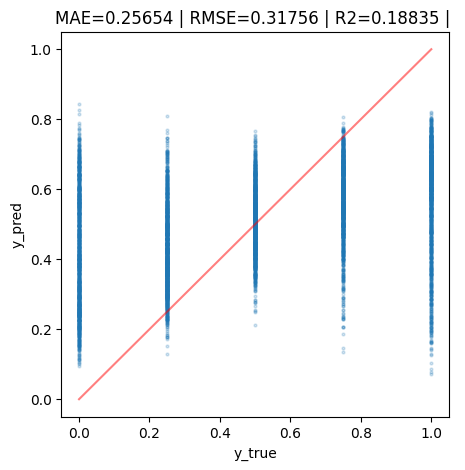

In [284]:
scatter_prediction_keras_mlp(keras_nn, scaled_trn_data,
                             geophysical_method,
                             determined_parameter,
                             "all", RS,
                             "stat_udus", "to_udfs", "stat_udus_udfs"
                             )

In [277]:
l_determined_parameter = ['H1_8', 'H2_8', 'H3_8']

vector_pred_NN(scaled_trn_data, scaled_vld_data, scaled_tst_data,
                         geophysical_method,
                         l_determined_parameter, 
                         "all", RS, 
                         "net_udus")

(1000, 0)
Start train model: net_udus_G_all_H1_8_rs1
Epoch 1/50000
20/20 - 0s - 23ms/step - loss: 0.1195 - val_loss: 0.0693
Epoch 2/50000
20/20 - 0s - 3ms/step - loss: 0.0710 - val_loss: 0.0669
Epoch 3/50000
20/20 - 0s - 3ms/step - loss: 0.0687 - val_loss: 0.0647
Epoch 4/50000
20/20 - 0s - 3ms/step - loss: 0.0664 - val_loss: 0.0626
Epoch 5/50000
20/20 - 0s - 3ms/step - loss: 0.0644 - val_loss: 0.0606
Epoch 6/50000
20/20 - 0s - 3ms/step - loss: 0.0624 - val_loss: 0.0587
Epoch 7/50000
20/20 - 0s - 4ms/step - loss: 0.0605 - val_loss: 0.0570
Epoch 8/50000
20/20 - 0s - 3ms/step - loss: 0.0588 - val_loss: 0.0553
Epoch 9/50000
20/20 - 0s - 3ms/step - loss: 0.0571 - val_loss: 0.0537
Epoch 10/50000
20/20 - 0s - 3ms/step - loss: 0.0555 - val_loss: 0.0522
Epoch 11/50000
20/20 - 0s - 3ms/step - loss: 0.0540 - val_loss: 0.0508
Epoch 12/50000
20/20 - 0s - 3ms/step - loss: 0.0526 - val_loss: 0.0495
Epoch 13/50000
20/20 - 0s - 3ms/step - loss: 0.0512 - val_loss: 0.0482
Epoch 14/50000
20/20 - 0s - 3ms/

c:\Users\Gavriil\VS_projects\KAN_geo\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0.19425, 0.23342, 0.39054]

### KAN

In [289]:
def get_KAN_dataset(trn_data, vld_data, tst_data,
                    geophysical_method, output_parameter, samples_number
                    ):
    
    _trn_data = copy.deepcopy(trn_data)
    _vld_data = copy.deepcopy(vld_data)
    _tst_data = copy.deepcopy(tst_data)
    _geophysical_method = copy.deepcopy(geophysical_method)
    _output_parameter = copy.deepcopy(output_parameter)    
    _samples_number = copy.deepcopy(samples_number)

    ### Create input-output data

    _dataset_sizes = {"all":"all", 3500:1000, 1750:500, 1000:300, 700:200, 350:100, 175:50}
    _X_trn, _Y_trn = create_XY_data(_trn_data, _output_parameter, _geophysical_method, _samples_number)
    _X_vld, _Y_vld = create_XY_data(_vld_data, _output_parameter, _geophysical_method, _dataset_sizes[_samples_number])
    _X_tst, _Y_tst = create_XY_data(_tst_data, _output_parameter, _geophysical_method, 'all')

    _tc_X_trn, _tc_Y_trn = torch.from_numpy(_X_trn.to_numpy()), torch.from_numpy(_Y_trn.to_numpy())
    _tc_X_vld, _tc_Y_vld = torch.from_numpy(_X_vld.to_numpy()), torch.from_numpy(_Y_vld.to_numpy())
    _tc_X_tst, _tc_Y_tst = torch.from_numpy(_X_tst.to_numpy()), torch.from_numpy(_Y_tst.to_numpy())

    dataset_3 = {'train_input': _tc_X_trn,
             'train_label': _tc_Y_trn,
             'val_input': _tc_X_vld,
             'val_label': _tc_Y_vld,
             'test_input': _tc_X_tst,
             'test_label': _tc_Y_tst}
    
    return dataset_3

In [322]:
def train_KAN(dataset_3,
                RS=1,
                K=3, # order of piecewise polynomial in B-splines
                hidden_neurons=1
                ):
    
    ### Create model
    INPUT_SHAPE = dataset_3['train_input'].shape[1]

    model = KAN_es(width=[INPUT_SHAPE, hidden_neurons, 1], grid=3, k=K, seed=RS)

    result = model.train_es(dataset_3,
                          tol=0.001, #0.0001
                          n_iter_no_change=25,
                          opt="LBFGS", steps=1000, 
                          lamb=0,
                          lamb_l1=1,
                          lamb_entropy=2)
    
    return model, result

In [333]:
def alg_KAN_model(trn_data, vld_data, tst_data,
                  geophysical_method, output_parameter, randomseed,
                  K=3,hidden_neurons=1
                  ):
    dataset_3 = get_KAN_dataset(trn_data, vld_data, tst_data,
                geophysical_method,
                output_parameter, 
                "all")
    
    model = train_KAN(dataset_3, randomseed, K=K, hidden_neurons=hidden_neurons)

    _Y_tst = dataset_3['test_label'].detach().numpy()
    _Y_pred = model[0].forward(dataset_3['test_input']).detach().numpy()

    _mae = round(mean_absolute_error(_Y_tst, _Y_pred), 5)
    _rmse = round(mean_squared_error(_Y_tst, _Y_pred, squared = False), 5)
    _r2 = round(r2_score(_Y_tst, _Y_pred), 5)

    return [_mae, _rmse, _r2]

In [342]:
def vector_pred_KAN(trn_data, vld_data, tst_data, 
                    geophysical_method, l_output_parameter, randomseed,
                    K=3,hidden_neurons=1):
    '''Conducting prediction for each output from l_output_parameter. 
    One KAN for each output_parameter from l_output_parameter.
    Return vector [mae, mse, r2]
    '''
    dataset_3 = get_KAN_dataset(trn_data, vld_data, tst_data,
                        geophysical_method, l_output_parameter[0], 'all')

    _vector_Y_pred = np.array([[] for i in range(dataset_3['test_label'].shape[0])])
    _vector_Y_tst = np.array([[] for i in range(dataset_3['test_label'].shape[0])])


    for output_parameter in l_output_parameter: 
        dataset_3 = get_KAN_dataset(trn_data, vld_data, tst_data,
                        geophysical_method, output_parameter, 'all')
        
        model = train_KAN(dataset_3,
                          RS=randomseed,
                          K=K,
                          hidden_neurons=hidden_neurons)
        
        _Y_tst = dataset_3['test_label'].detach().numpy()
        _Y_pred = model[0].forward(dataset_3['test_input']).detach().numpy()
        
        _vector_Y_pred = np.concatenate((_vector_Y_pred, _Y_pred), axis=1)
        _vector_Y_tst = np.concatenate((_vector_Y_tst, _Y_tst), axis=1)
        
    _mae = round(mean_absolute_error(_vector_Y_tst, _vector_Y_pred), 5)
    _rmse = round(mean_squared_error(_vector_Y_tst, _vector_Y_pred, squared = False), 5)
    _r2 = round(r2_score(_vector_Y_tst, _vector_Y_pred), 5)

    return [_mae, _rmse, _r2]


In [339]:
def scatter_prediction_kan(model, 
                           x, 
                           y_true, 
                           title = ""):
    """Evaluates MSE and R^2 of model. 
    Draws scatter plot of (y_true, y_predicted).
    Returns  (mse, r2)
    """
    y_pred = model.forward(x).detach().numpy()
    y_true = y_true.detach().numpy()
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(y_true, y_pred, 'o', markersize=2, alpha = 0.2) 
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], markersize=2, alpha = 0.5, color='r') 
    ax.set_title(f"MSE={round(mse, 5)} | RMSE={round(mse**0.5, 5)} | R2={round(r2, 5)} | {title}")
    ax.set_xlabel("y_true")
    ax.set_ylabel("y_pred")
    plt.show()
    
    return mse, r2

In [334]:
alg_KAN_model(scaled_trn_data, scaled_vld_data, scaled_tst_data,
                geophysical_method,
                determined_parameter, 
                randomseed=1)

description:   0%|                                                                                       | 0/1000 [00:00<?, ?it/s]

trn_ls: 6.18e-02 | vl_ls: 6.32e-02 | e_stop: 25/25 | tst_ls: 6.13e-02 | reg: 3.41e+01 :   3%|   | 33/1000 [01:22<40:11,  2.49s/it]

Early stopping criteria raised



c:\Users\Gavriil\VS_projects\KAN_geo\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0.0487, 0.06126, 0.94647]

In [343]:
l_determined_parameter = ['H1_8', 'H2_8', 'H3_8']

vector_pred_KAN(scaled_trn_data, scaled_vld_data, scaled_tst_data,
                geophysical_method,
                l_determined_parameter, 
                randomseed=1)

trn_ls: 6.30e-02 | vl_ls: 6.49e-02 | e_stop: 25/25 | tst_ls: 6.31e-02 | reg: 3.67e+01 :   3%|   | 27/1000 [01:06<39:43,  2.45s/it]


Early stopping criteria raised


trn_ls: 1.57e-01 | vl_ls: 1.62e-01 | e_stop: 25/25 | tst_ls: 1.56e-01 | reg: 3.66e+01 :  12%|▏ | 120/1000 [04:50<35:27,  2.42s/it]


Early stopping criteria raised


trn_ls: 3.08e-01 | vl_ls: 3.11e-01 | e_stop: 25/25 | tst_ls: 3.05e-01 | reg: 2.60e+01 :   3%|   | 27/1000 [01:06<39:49,  2.46s/it]

Early stopping criteria raised



c:\Users\Gavriil\VS_projects\KAN_geo\.venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[0.13916, 0.1749, 0.64519]

In [297]:
#geophysical_method = 'G'
#determined_parameter = 'H3_8'
RS = 1

dataset_3 = get_KAN_dataset(scaled_trn_data, scaled_vld_data, scaled_tst_data,
                geophysical_method,
                determined_parameter, 
                "all")

model1, result1 = train_KAN(dataset_3, RS, K=3)

trn_ls: 3.06e-01 | vl_ls: 3.10e-01 | e_stop: 25/25 | tst_ls: 3.05e-01 | reg: 2.89e+01 :   6%|▏  | 65/1000 [02:38<37:53,  2.43s/it]

Early stopping criteria raised


Text(0.5, 0, 'step')

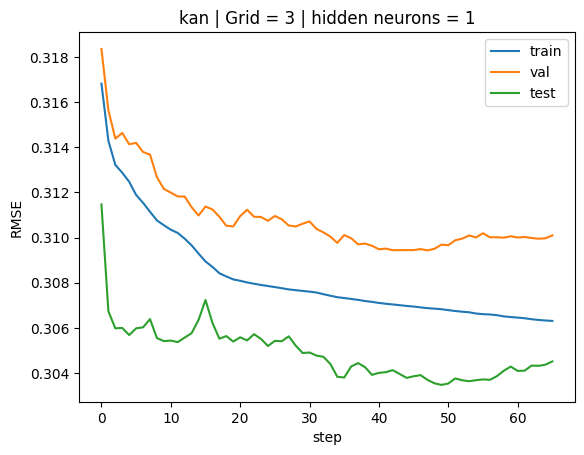

In [298]:
plt.plot(result1['train_loss'])
plt.plot(result1['val_loss'])
plt.plot(result1['test_loss'])

#plt.plot(result1['reg'])
plt.legend(['train', 'val',  'test']) #, 'reg'
plt.title('kan | Grid = 3 | hidden neurons = 1')
plt.ylabel('RMSE')
plt.xlabel('step')

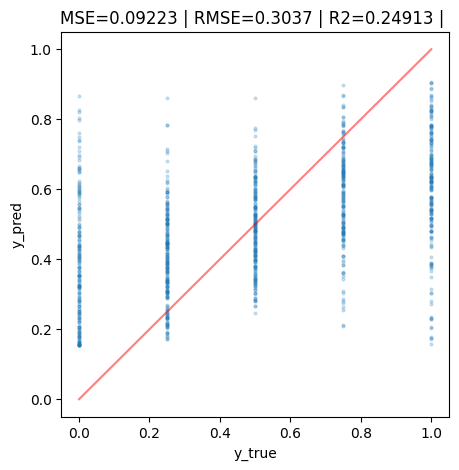

(0.09223187699762563, 0.24912633644019522)

In [299]:
scatter_prediction_kan(model1,
                       dataset_3['test_input'],
                       dataset_3['test_label'])

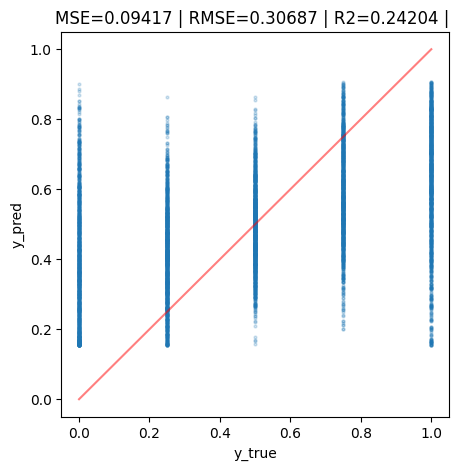

(0.09417164632065633, 0.24204332621182034)

In [300]:
scatter_prediction_kan(model1,
                       dataset_3['train_input'],
                       dataset_3['train_label'])

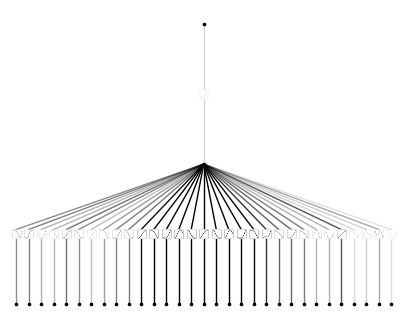

In [232]:
model1.plot()

### 3.1. UDUS-UDFS

In [16]:
for random_seed in RANDOM_SEEDS:
    
    all_stat_DF = pd.DataFrame(columns = ['epochs', 'MAE', 'RMSE', 'R2'])
    
    for geophysical_method in GEOPHYSICAL_METHODS:
        for determined_parameter in DETERMINED_PARAMETERS:
            
            pretrained_NN = train_NN(scaled_trn_data_udus, scaled_vld_data_udus,
                                     geophysical_method,
                                     determined_parameter, 
                                     "all", random_seed, 
                                     "net_udus", "nets_udus_udfs")
            
            stat_DF = app_stat_NN(pretrained_NN, scaled_tst_data_udfs,
                                  geophysical_method,
                                  determined_parameter, 
                                  "all", random_seed, 
                                  "stat_udus", "to_udfs", "stat_udus_udfs")
            
            all_stat_DF = pd.concat([all_stat_DF, stat_DF], axis=0, sort=False) 
            
            reference_NN = train_NN(scaled_trn_data_udfs, scaled_vld_data_udfs, 
                                    geophysical_method,
                                    determined_parameter, 
                                    "all", random_seed, 
                                    "net_udfs", "nets_udus_udfs")
            
            stat_DF = app_stat_NN(reference_NN, scaled_tst_data_udfs,
                                  geophysical_method,
                                  determined_parameter,
                                  "all", random_seed, 
                                  "stat_udfs", "to_udfs", "stat_udus_udfs")
            
            all_stat_DF = pd.concat([all_stat_DF, stat_DF], axis=0, sort=False)
            
            for dataset_size in DATASET_SIZES:
                
                fine_tuned_NN = fine_tune_NN(pretrained_NN[0], 
                                             scaled_trn_data_udfs, scaled_vld_data_udfs,
                                             geophysical_method,
                                             determined_parameter,
                                             dataset_size, 
                                             random_seed, 
                                             "net_udus_udfs", "nets_udus_udfs")                                        
                
                stat_DF = app_stat_NN(fine_tuned_NN, scaled_tst_data_udfs,
                                      geophysical_method,
                                      determined_parameter, 
                                      dataset_size, 
                                      random_seed, 
                                      "stat_udus_udfs", "to_udfs", "stat_udus_udfs")
                
                all_stat_DF = pd.concat([all_stat_DF, stat_DF], axis=0, sort=False)
                
                reference_NN = train_NN(scaled_trn_data_udfs, scaled_vld_data_udfs,
                                        geophysical_method,
                                        determined_parameter,
                                        dataset_size, 
                                        random_seed, 
                                        "net_udfs", "nets_udus_udfs")
                
                stat_DF = app_stat_NN(reference_NN, scaled_tst_data_udfs,
                                      geophysical_method,
                                      determined_parameter,
                                      dataset_size, 
                                      random_seed, 
                                      "stat_udfs", "to_udfs", "stat_udus_udfs")
                
                all_stat_DF = pd.concat([all_stat_DF, stat_DF], axis=0, sort=False)
            
    all_stat_DF.to_csv("stat_udus_udfs_rs"+str(random_seed)+".csv")

Start train model: net_udus_G_all_H1_8_rs111


KeyboardInterrupt: 

### 3.2. UDUS-FDFS

### 3.3. UDFS-FDFS